# Зависимости

In [1]:
!pip install pywavelets mne --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 24.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 48.9 MB/s eta 0:00:00


In [2]:
# подгружаем библиотеки
import pywt
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import mne

In [3]:
# фильтр Баттерфорда для вырезания полосы частот
from scipy import signal
def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = signal.butter(order, [low, high], btype='band')
    filtered_data = signal.lfilter(b, a, data)
    return filtered_data

# ЛР 2

In [5]:
from google.colab import drive
drive.mount('/content/drive')

# EEG_21
edf_path = '/content/drive/MyDrive/Example4/eeg13.edf'
annotations_path = '/content/drive/MyDrive/Example4/annotations_2017_A.csv'

Mounted at /content/drive


Определяем интервалы приступов

In [38]:
import pandas as pd

# читаем аннотации эксперта А
ann = pd.read_csv(annotations_path)

# столбец '17'
col = ann['13']

# находим индексы  с приступом
idx = col[col == 1].index.to_numpy()

# разбиваем на непрерывные блоки:
blocks = []
start = idx[0]
prev = idx[0]
for i in idx[1:]:
    if i == prev + 1:
        prev = i
    else:
        blocks.append((start, prev))
        start = prev = i
blocks.append((start, prev))
# выводим интервалы (в секундах)
for s, e in blocks:
    print(f"Приступ с {s}s по {e}s (длительность {e-s+1}s)")

start,end = blocks[4]

Приступ с 0s по 291s (длительность 292s)
Приступ с 800s по 1295s (длительность 496s)
Приступ с 8511s по 8622s (длительность 112s)
Приступ с 8839s по 9071s (длительность 233s)
Приступ с 9370s по 9507s (длительность 138s)


In [39]:
# загрузка файла
data_from_raw_edf = mne.io.read_raw_edf(edf_path, preload=True)
data_from_raw_edf.info

Extracting EDF parameters from /content/drive/MyDrive/Example4/eeg13.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 3946495  =      0.000 ... 15415.996 secs...


<ipython-input-39-3a2e4f4eb21c>:2: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  data_from_raw_edf = mne.io.read_raw_edf(edf_path, preload=True)
<ipython-input-39-3a2e4f4eb21c>:2: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  data_from_raw_edf = mne.io.read_raw_edf(edf_path, preload=True)


<Info | 8 non-empty values
 bads: []
 ch_names: EEG Fp1-Ref, EEG Fp2-Ref, EEG F3-Ref, EEG F4-Ref, EEG F7-Ref, ...
 chs: 21 EEG
 custom_ref_applied: False
 highpass: 1.0 Hz
 lowpass: 128.0 Hz
 meas_date: 2011-11-11 11:11:11 UTC
 nchan: 21
 projs: []
 sfreq: 256.0 Hz
 subject_info: <subject_info | his_id: >
>

['EEG Fp1-Ref', 'EEG Fp2-Ref', 'EEG F3-Ref', 'EEG F4-Ref', 'EEG F7-Ref', 'EEG F8-Ref', 'EEG Fz-Ref', 'EEG C3-Ref', 'EEG C4-Ref', 'EEG Cz-Ref', 'EEG T3-Ref', 'EEG T5-Ref', 'EEG T4-Ref', 'EEG T6-Ref', 'EEG P3-Ref', 'EEG P4-Ref', 'EEG Pz-Ref', 'EEG O1-Ref', 'EEG O2-Ref', 'ECG EKG', 'Resp Effort']


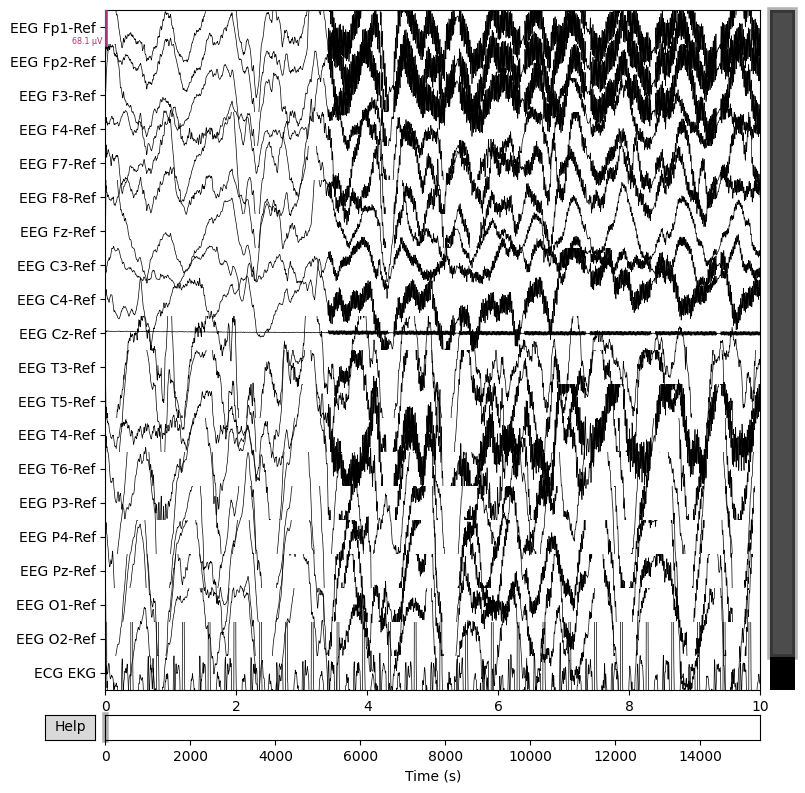

In [40]:
data_from_raw_edf.plot(scalings = 'auto', show = False)
# список каналов из файла EDF
print(data_from_raw_edf.ch_names)

Отобразим только интервал приступа

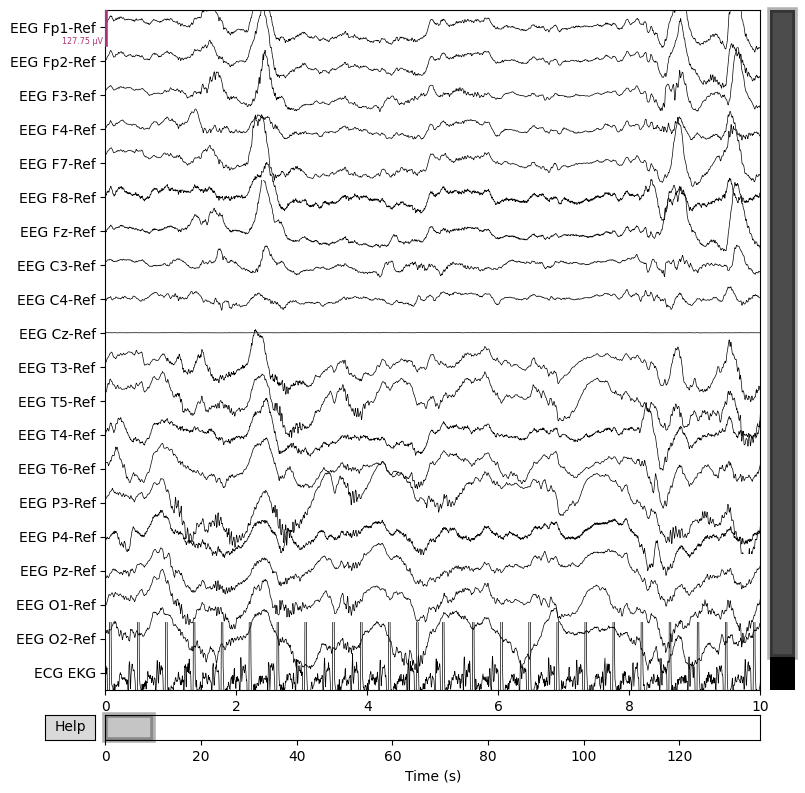

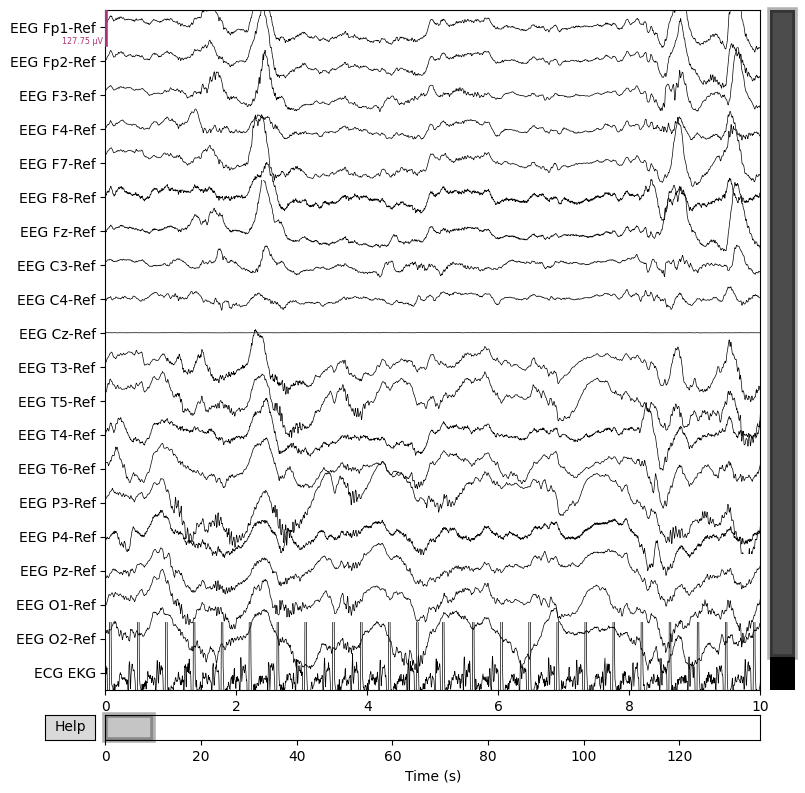

In [41]:
raw_interval = data_from_raw_edf.copy().crop(tmin=start, tmax=end)
raw_interval.plot(scalings='auto', show=True)

Загрузим в виде np

In [49]:
eeg_data, eeg_times = data_from_raw_edf.get_data(return_times=True)
print('число отчетов во временном ряду:',len(eeg_times))
# устанавливаем диапазон для обработки данных
t_index_begin = np.where(eeg_times > 1*start -50)[0][0]
t_index_end = np.where(eeg_times > 1*end + 50)[0][0]
t = eeg_times[t_index_begin:t_index_end]
# значение времени = конец сигнала
T = t[-1] - t[0]
# число элементов во временном ряду
N = len(t)

# удалаем ненужные сигналы из массива данных ЭЭГ
# в случае сигнала EEG_21 8 канал 'Value MKR+-MKR-'
eeg_data = np.delete(eeg_data, [len(eeg_data)-1], axis = 0)

число отчетов во временном ряду: 3946496


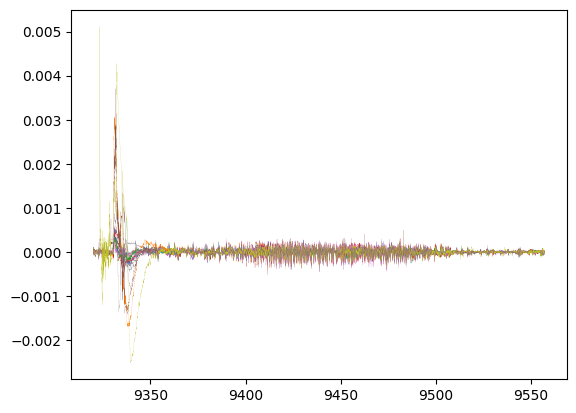

In [50]:
for i in range(len(data_from_raw_edf.ch_names)-2):
    plt.plot(t, eeg_data[i, t_index_begin:t_index_end],linewidth = 0.1)
plt.show()

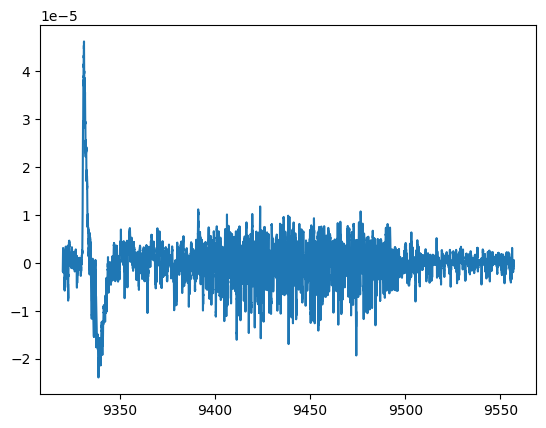

In [51]:
# сделаем простой устредненный сигнал - все каналы в один массив
y=[]
for i in range(len(eeg_data)-2):
    y =+ eeg_data[i, t_index_begin:t_index_end]
y =y/(len(eeg_data)-1)
plt.plot(t,y)

Удалим частоты выше 60

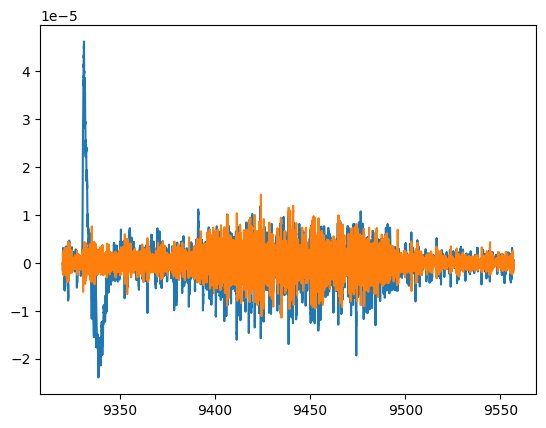

In [52]:
# Пример предобработки: фильтрация сигнала
fs = len(t)/(T)  # частота дискретизации
lowcut = 1 # нижняя частота среза фильтра
highcut = 60 # верхняя частота среза фильтра
y_filt = np.apply_along_axis(butter_bandpass_filter, axis=0, arr=y, lowcut=lowcut, highcut=highcut, fs=fs)
plt.plot(t,y, t, y_filt)
y = y_filt

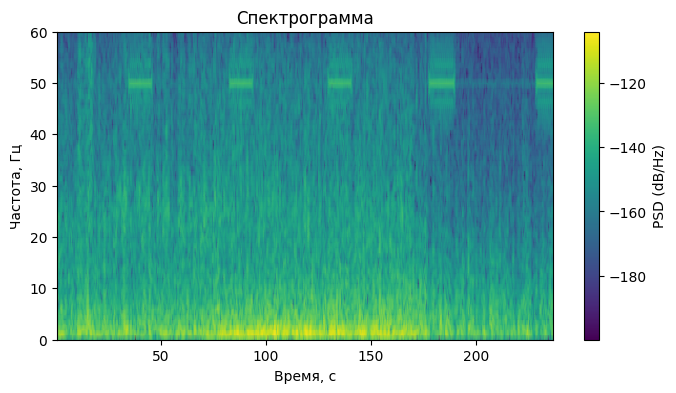

In [53]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import spectrogram

f, t_spec, Sxx = spectrogram(y, fs=fs, nperseg=256, noverlap=128)

# переводим в децибелы
Sxx_dB = 10 * np.log10(Sxx + 1e-20)

# рисуем
plt.figure(figsize=(8, 4))
plt.pcolormesh(t_spec, f, Sxx_dB, shading='gouraud')
plt.colorbar(label='PSD (dB/Hz)')
plt.ylabel('Частота, Гц')
plt.xlabel('Время, с')
plt.title('Спектрограмма')
plt.ylim(0, 60)
plt.show()


Делаем wavelet

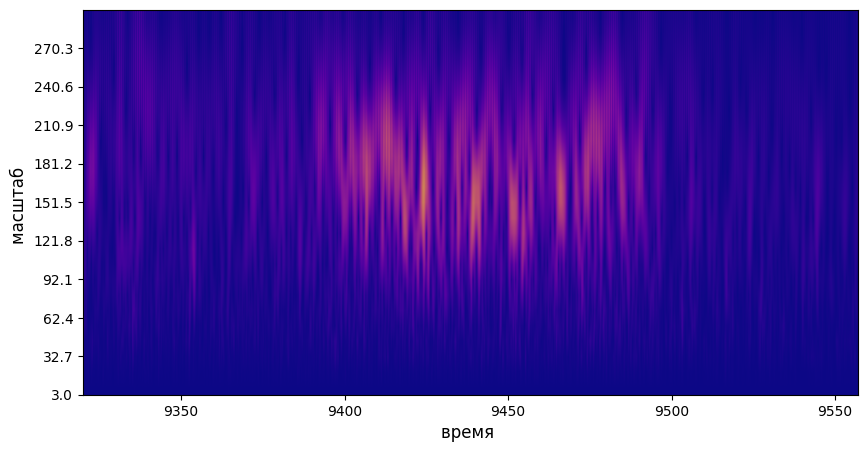

In [54]:
scale_max = 300
scale_min = 3
# массив точек с масштабом (линейный и логарифмический масштаб)
scales = np.linspace(scale_min, scale_max, num = 25, endpoint=True)

wavelet_core = 'morl'
fs = len(t)/(T)  # частота дискретизации
dt = 1/ fs
coef, freqs = pywt.cwt(y, scales, wavelet_core, sampling_period = dt)
f = pywt.scale2frequency(wavelet_core, scales)/dt
#Plotting scalogram
plt.figure(figsize=(10, 5))
plt.imshow(abs(coef), extent=[t[0], t[-1], max(scales), min(scales)], interpolation='bilinear', cmap='plasma', aspect='auto')
plt.gca().invert_yaxis ()
plt.yticks(np.arange(min(scales), max(scales), (max(scales) - min(scales))/10))
plt.ylabel('масштаб ', fontsize=12)
plt.xlabel('время ', fontsize=12)
plt.show()